In [ ]:
import os
import torch
import torchvision
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from tqdm import tqdm

import time
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/My Drive/cs5242-project
!pwd
import utils

/content/drive/My Drive/cs5242-project
/content/drive/My Drive/cs5242-project


In [ ]:
# Looking into the directory
data_dir = './dataset'
print(os.listdir(data_dir))
classes_train = os.listdir(data_dir + "/train")
classes_valid = os.listdir(data_dir + "/validation")
print(f'Train Classes - {classes_train}')
print(f'Validation Classes - {classes_valid}')

['train', 'validation', 'train.csv', 'test.csv']
Train Classes - ['disgusted', 'happy', 'neutral', 'surprised', 'scared', 'sad', 'angry']
Validation Classes - ['surprised', 'disgusted', 'neutral', 'angry', 'sad', 'scared', 'happy']


In [ ]:
# Data transforms (Gray Scaling & data augmentation)
train_tfms = tt.Compose([tt.Grayscale(num_output_channels=1),
                         tt.RandomHorizontalFlip(),
                         tt.RandomRotation(30),
                         tt.Resize((32,32)),
                         tt.ToTensor()])

valid_tfms = tt.Compose([tt.Grayscale(num_output_channels=1), tt.Resize((32,32)), tt.ToTensor()])

In [ ]:
# Emotion Detection datasets
train_ds = ImageFolder(data_dir + '/train', train_tfms)
valid_ds = ImageFolder(data_dir + '/validation', valid_tfms)

In [ ]:
batch_size = 50

In [ ]:
# PyTorch data loaders
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size, num_workers=2, pin_memory=True)

In [ ]:
device= torch.device("cuda")
#device= torch.device("cpu")
print(device)

cuda


# VGG Neural Networks

Over here, we train a simple VGG, a Very Deep Convolutional Networks for Large-Scale Image Recognition which was propsed by Visual Geometry Group in 2014.


In [ ]:
class VGG_convnet(nn.Module):

    def __init__(self):

        super(VGG_convnet, self).__init__()

        # block 1:         1 x 32 x 32 --> 64 x 16 x 16        
        self.conv1a = nn.Conv2d(1,   64,  kernel_size=3, padding=1 )
        self.conv1b = nn.Conv2d(64,  64,  kernel_size=3, padding=1 )
        self.pool1  = nn.MaxPool2d(2,2)

        # block 2:         64 x 16 x 16 --> 128 x 8 x 8
        self.conv2a = nn.Conv2d(64,  128, kernel_size=3, padding=1 )
        self.conv2b = nn.Conv2d(128, 128, kernel_size=3, padding=1 )
        self.pool2  = nn.MaxPool2d(2,2)

        # block 3:         128 x 8 x 8 --> 256 x 4 x 4        
        self.conv3a = nn.Conv2d(128, 256, kernel_size=3, padding=1 )
        self.conv3b = nn.Conv2d(256, 256, kernel_size=3, padding=1 )
        self.pool3  = nn.MaxPool2d(2,2)
        
        #block 4:          256 x 4 x 4 --> 512 x 2 x 2
        self.conv4a = nn.Conv2d(256, 512, kernel_size=3, padding=1 )
        self.pool4  = nn.MaxPool2d(2,2)

        # linear layers:   512 x 2 x 2 --> 2048 --> 4096 --> 4096 --> 10
        self.linear1 = nn.Linear(2048, 4096)
        self.linear2 = nn.Linear(4096,4096)
        self.linear3 = nn.Linear(4096, 10)


    def forward(self, x):

        # block 1:         3 x 32 x 32 --> 64 x 16 x 16
        x = self.conv1a(x)
        x = F.relu(x)
        x = self.conv1b(x)
        x = F.relu(x)
        x = self.pool1(x)

        # block 2:         64 x 16 x 16 --> 128 x 8 x 8
        x = self.conv2a(x)
        x = F.relu(x)
        x = self.conv2b(x)
        x = F.relu(x)
        x = self.pool2(x)

        # block 3:         128 x 8 x 8 --> 256 x 4 x 4
        x = self.conv3a(x)
        x = F.relu(x)
        x = self.conv3b(x)
        x = F.relu(x)
        x = self.pool3(x)

        #block 4:          256 x 4 x 4 --> 512 x 2 x 2
        x = self.conv4a(x)
        x = F.relu(x)
        x = self.pool4(x)

        # linear layers:   512 x 2 x 2 --> 2048 --> 4096 --> 4096 --> 10
        x = x.view(-1, 2048)
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = F.relu(x)
        x = self.linear3(x) 
        
        return x

In [ ]:
net=VGG_convnet()

print(net)
utils.display_num_param(net)

VGG_convnet(
  (conv1a): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1b): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2a): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2b): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3a): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3b): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4a): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=2048, out_features=4096, bias=True)
  (linear2): Linear(i

In [ ]:
net = net.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
my_lr=0.25  

In [ ]:
def eval_on_test_set():

    running_error=0
    num_batches=0

    for minibatch_data, minibatch_label in valid_dl:
        # send them to the gpu
        minibatch_data=minibatch_data.to(device)
        minibatch_label=minibatch_label.to(device)

        # reshape the minibatch
        inputs = minibatch_data.view(-1, 1, 32, 32)

        # feed it to the network
        scores=net( inputs ) 

        # compute the error made on this batch
        error = utils.get_error( scores , minibatch_label)

        # add it to the running error
        running_error += error.item()

        num_batches+=1


    # compute error rate on the full test set
    total_error = running_error/num_batches

    print( 'error rate on test set =', total_error*100 ,'percent')

In [ ]:
start=time.time()

for epoch in range(1,200):
    
    # divide the learning rate by 2 at epoch 10, 14 and 18
    if epoch==10 or epoch == 14 or epoch==18:
        my_lr = my_lr / 2
    
    # create a new optimizer at the beginning of each epoch: give the current learning rate.   
    optimizer=torch.optim.SGD( net.parameters() , lr=my_lr )
        
    # set the running quatities to zero at the beginning of the epoch
    running_loss=0
    running_error=0
    num_batches=0
    
    for minibatch_data, minibatch_label in train_dl:
        # Set the gradients to zeros
        optimizer.zero_grad()
        
        # send them to the gpu
        minibatch_data=minibatch_data.to(device)
        minibatch_label=minibatch_label.to(device)
        
        # reshape the minibatch
        inputs = minibatch_data.view(-1, 1, 32, 32)

        # tell Pytorch to start tracking all operations that will be done on "inputs"
        inputs.requires_grad_()

        # forward the minibatch through the net 
        scores=net( inputs ) 

        # Compute the average of the losses of the data points in the minibatch
        loss =  criterion( scores , minibatch_label) 
        
        # backward pass to compute dL/dU, dL/dV and dL/dW   
        loss.backward()

        # do one step of stochastic gradient descent: U=U-lr(dL/dU), V=V-lr(dL/dU), ...
        optimizer.step()
        

        # START COMPUTING STATS
        
        # add the loss of this batch to the running loss
        running_loss += loss.detach().item()
        
        # compute the error made on this batch and add it to the running error       
        error = utils.get_error( scores.detach() , minibatch_label)
        running_error += error.item()
        
        num_batches+=1        
    
    
    # compute stats for the full training set
    total_loss = running_loss/num_batches
    total_error = running_error/num_batches
    elapsed = (time.time()-start)/60
    

    print('epoch=',epoch, '\t time=', elapsed,'min','\t lr=', my_lr  ,'\t loss=', total_loss , '\t error=', total_error*100 ,'percent')
    eval_on_test_set() 
    print(' ')

epoch= 1 	 time= 0.16052822271982828 min 	 lr= 0.25 	 loss= 2.019545246645347 	 error= 82.12371173593186 percent
error rate on test set = 81.45454525947571 percent
 
epoch= 2 	 time= 0.33595306078592935 min 	 lr= 0.25 	 loss= 1.9555120480429267 	 error= 82.08247478475276 percent
error rate on test set = 81.27272725105286 percent
 
epoch= 3 	 time= 0.5116730650266011 min 	 lr= 0.25 	 loss= 1.9491242944579763 	 error= 82.30927869216683 percent
error rate on test set = 81.27272725105286 percent
 
epoch= 4 	 time= 0.6883858442306519 min 	 lr= 0.25 	 loss= 1.9464216392064833 	 error= 81.62886629399566 percent
error rate on test set = 81.27272725105286 percent
 
epoch= 5 	 time= 0.8643346468607584 min 	 lr= 0.25 	 loss= 1.9442517732836537 	 error= 81.29896933270484 percent
error rate on test set = 87.09090948104858 percent
 
epoch= 6 	 time= 1.036573048432668 min 	 lr= 0.25 	 loss= 1.9432222646536286 	 error= 81.83505227885294 percent
error rate on test set = 81.27272725105286 percent
 
epoc

# VGG -- nn.MaxPool2d(4 x 4)
The attempted improvement done over here is to increase the size of the average pooling layers from 2x2 to 4x4. This was done for multiple reasons.

We do not wish to resize the input layer of 1x128x128 first because this image classification tasks deals with facial expressions and facial features which are detailed and may contain useful features for each small pixel. However, due to the size of the input layer, it results in a number of parameters in the neural network. This may result in overfitting.

Hence, to reduce the number of parameters, while seeking to retain the information captured at fine-grain pixel level, we attemp to increase the size of the average pooling layers.

In [ ]:
class VGG_convnet_px128(nn.Module):

    def __init__(self):
        super(VGG_convnet, self).__init__()

        # block 1:         1 x 128 x 128 --> 64 x 32 x 32
        self.conv1a = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.conv1b = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(4, 4)

        # block 2:         64 x 32 x 32 --> 128 x 8 x 8
        self.conv2a = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv2b = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(4, 4)

        # block 3:         128 x 8 x 8 --> 256 x 4 x 4
        self.conv3a = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv3b = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)

        # block 4:          256 x 4 x 4 --> 512 x 2 x 2
        self.conv4a = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.pool4 = nn.MaxPool2d(2, 2)

        # linear layers:   512 x 2 x 2 --> 2048 --> 4096 --> 4096 --> 10
        self.linear1 = nn.Linear(2048, 4096)
        self.linear2 = nn.Linear(4096, 4096)
        self.linear3 = nn.Linear(4096, 10)

    def forward(self, x):
        # block 1:         1 x 128 x 128 --> 64 x 64 x 64
        x = self.conv1a(x)
        x = F.relu(x)
        x = self.conv1b(x)
        x = F.relu(x)
        x = self.pool1(x)

        # block 2:         64 x 64 x 64 --> 128 x 16 x 16
        x = self.conv2a(x)
        x = F.relu(x)
        x = self.conv2b(x)
        x = F.relu(x)
        x = self.pool2(x)

        # block 3:         128 x 16 x 16 --> 256 x 4 x 4
        x = self.conv3a(x)
        x = F.relu(x)
        x = self.conv3b(x)
        x = F.relu(x)
        x = self.pool3(x)

        # block 4:          256 x 4 x 4 --> 512 x 2 x 2
        x = self.conv4a(x)
        x = F.relu(x)
        x = self.pool4(x)

        # linear layers:   512 x 2 x 2 --> 2048 --> 4096 --> 4096 --> 10
        x = x.view(-1, 2048)
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = F.relu(x)
        x = self.linear3(x)

        return x
    
'''
utils.display_num_param(net)

VGG_convnet_px128(
  (conv1a): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1b): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2a): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2b): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3a): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3b): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4a): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=2048, out_features=4096, bias=True)
  (linear2): Linear(in_features=4096, out_features=4096, bias=True)
  (linear3): Linear(in_features=4096, out_features=10, bias=True)
  There are 27539402 (27.54 million) parameters in this neural network
)
'''

'''
See log/vgg_px128.txt for the full output.
 
epoch= 197 	 time= 13.116444532076518 min 	 lr= 0.03125 	 loss= 0.1217539941642395 	 error= 4.123713613785419 percent
error rate on test set = 53.06818268515847 percent
 
epoch= 198 	 time= 13.181400994459787 min 	 lr= 0.03125 	 loss= 0.10981417798734817 	 error= 3.4639196912037957 percent
error rate on test set = 49.53409162434665 percent
 
epoch= 199 	 time= 13.245910755793254 min 	 lr= 0.03125 	 loss= 0.10294757859262917 	 error= 3.216496878063556 percent
error rate on test set = 50.806818767027416 percent
'''


# Dropout
We find that the error rate on the train set is much higher than the test set.

In order to combat overfitting in the network, we try inserting Dropout layers after convolutional layers.

In [ ]:
class VGG_convnet_dropout(nn.Module):

    def __init__(self):
        super(VGG_convnet, self).__init__()

        # block 1:         1 x 128 x 128 --> 64 x 32 x 32
        self.conv1a = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.conv1b = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(4, 4)

        # block 2:         64 x 32 x 32 --> 128 x 8 x 8
        self.conv2a = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv2b = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(4, 4)

        # block 3:         128 x 8 x 8 --> 256 x 4 x 4
        self.conv3a = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv3b = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)

        # block 4:          256 x 4 x 4 --> 512 x 2 x 2
        self.conv4a = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.pool4 = nn.MaxPool2d(2, 2)

        # linear layers:   512 x 2 x 2 --> 2048 --> 4096 --> 4096 --> 10
        self.linear1 = nn.Linear(2048, 4096)
        self.linear2 = nn.Linear(4096, 4096)
        self.linear3 = nn.Linear(4096, 10)

    def forward(self, x):
        # block 1:         1 x 128 x 128 --> 64 x 32 x 32
        x = self.conv1a(x)
        x = F.relu(x)
        x = self.conv1b(x)
        x = F.relu(x)
        x = self.pool1(x)

        # block 2:         64 x 32 x 32 --> 128 x 8 x 8
        x = self.conv2a(x)
        x = F.relu(x)
        x = self.conv2b(x)
        x = F.relu(x)
        x = self.pool2(x)

        # block 3:         128 x 8 x 8 --> 256 x 4 x 4
        x = self.conv3a(x)
        x = F.relu(x)
        x = self.conv3b(x)
        x = F.relu(x)
        x = self.pool3(x)

        # block 4:          256 x 4 x 4 --> 512 x 2 x 2
        x = self.conv4a(x)
        x = F.relu(x)
        x = self.pool4(x)

        # linear layers:   512 x 2 x 2 --> 2048 --> 4096 --> 4096 --> 10
        x = x.view(-1, 2048)
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = F.relu(x)
        x = self.linear3(x)

        return x

'''
VGG_convnet(     
  (conv1a): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1b): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (drop1): Dropout(p=0.5, inplace=False)
  (conv2a): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2b): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (drop2): Dropout(p=0.5, inplace=False)
  (conv3a): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3b): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop3): Dropout(p=0.5, inplace=False)
  (conv4a): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=2048, out_features=4096, bias=True)
  (linear2): Linear(in_features=4096, out_features=4096, bias=True)
  (linear3): Linear(in_features=4096, out_features=10, bias=True)
)
There are 27539402 (27.54 million) parameters in this neural network
'''

'''
See log/vgg_dropout.txt for the full output.
 
epoch= 196 	 time= 13.345274138450623 min 	 lr= 0.03125 	 loss= 0.5204616894119793 	 error= 19.60824961514817 percent
error rate on test set = 49.590908939188175 percent
 
epoch= 197 	 time= 13.412516383330027 min 	 lr= 0.03125 	 loss= 0.5394029445254925 	 error= 20.49484738369578 percent
error rate on test set = 50.23863857442682 percent
 
epoch= 198 	 time= 13.479526805877686 min 	 lr= 0.03125 	 loss= 0.5349615907546171 	 error= 19.793816694279307 percent
error rate on test set = 50.943182273344554 percent
 
epoch= 199 	 time= 13.546925719579061 min 	 lr= 0.03125 	 loss= 0.5200335079247189 	 error= 19.31958985082882 percent
error rate on test set = 50.69318251176313 percent
'''


# Choice of Optimizer

We try three optimizers:
+ SGD
+ SGD + Momentum
+ Adam

For fare comparision, we use the default values of learning rate, beta1 and beta2 in pytorch.


Our observations:

+ Convergence. Adaptive optimizers such as Adam give fatser convergence than SGD and Momentum SGD, but it may get stuck in a local minima somehow and provides poor generalization

+ Global minima. SGD+momentum can achieve to find a global minima, but it relies on robust initializations and it might take longer than Adam to converge



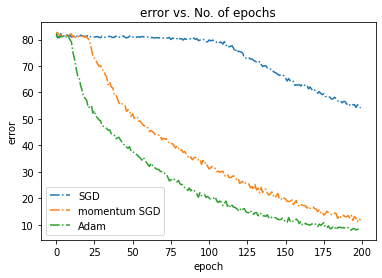

In [7]:
utils.plot_optimizers('error')

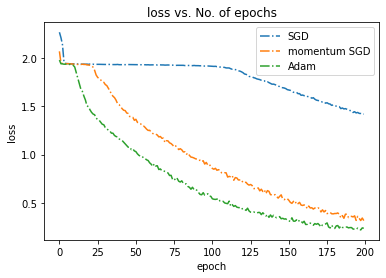

In [8]:
 utils.plot_optimizers('loss')

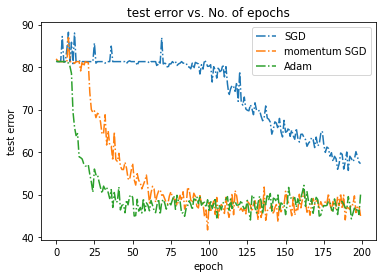

In [9]:
import utils
utils.plot_optimizers('test error')

## SGD

In [ ]:
optimizer = torch.optim.SGD(net.parameters(), lr=0.01)

'''
See log/optimizer_sgd.txt for the full output.

epoch= 197 	 time= 16.640492721398672 min 	 loss= 1.4266390739027988 	 error= 55.340207421902534 percent
error rate on test set = 58.886363831433385 percent
epoch= 198 	 time= 16.727175052960714 min 	 loss= 1.4200772022463612 	 error= 54.90721771397542 percent
error rate on test set = 57.602274959737606 percent
epoch= 199 	 time= 16.81212347348531 min 	 loss= 1.4205077726816393 	 error= 54.08247543364456 percent
error rate on test set = 57.27272792295977 percent
'''

## SGD + Momentum

In [ ]:
# Momentum SGD
optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

'''
See log/optimizer_sgd_momentum.txt for the full output.

epoch= 197 	 time= 17.621728281180065 min 	 loss= 0.31581137352383015 	 error= 11.175260347189363 percent
error rate on test set = 47.12500084530223 percent
epoch= 198 	 time= 17.705276453495024 min 	 loss= 0.3418008195063503 	 error= 12.350518064400584 percent
error rate on test set = 47.30681831186468 percent
epoch= 199 	 time= 17.794385369618734 min 	 loss= 0.31510837414522763 	 error= 11.711342617408517 percent
error rate on test set = 44.95454647324302 percent
'''

## Adam

In [ ]:
# Adam
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)

'''
See log/optimizer_adam.txt for the full output.

epoch= 197 	 time= 14.945561536153157 min 	 lr= 0.0001 	 loss= 0.21837057687879838 	 error= 8.247424523854994 percent
error rate on test set = 46.76136482845653 percent
epoch= 198 	 time= 15.016908542315166 min 	 lr= 0.0001 	 loss= 0.239205996246682 	 error= 8.536084964103305 percent
error rate on test set = 45.306819677352905 percent
epoch= 199 	 time= 15.092707566420238 min 	 lr= 0.0001 	 loss= 0.23558733973306478 	 error= 8.247424953991604 percent
error rate on test set = 49.977273832667954 percent
'''

# Validate Model Using Standard Dataset
We train our model a public dataset [fer-2013](https://www.kaggle.com/msambare/fer2013).

The data consists of 48x48 pixel grayscale images of faces. The faces have been automatically registered so that the face is more or less centred and occupies about the same amount of space in each image.

In [ ]:
'''
See log/vgg_fer_2013.txt for the full output.

epoch= 197 	 time= 70.96889228026072 min 	 loss= 0.1701572123931154 	 error= 5.754978128101515 percent
error rate on test set = 37.50396979351838 percent
epoch= 198 	 time= 71.32047909498215 min 	 loss= 0.1636838308264218 	 error= 5.540871723838475 percent
error rate on test set = 37.52678744494915 percent
epoch= 199 	 time= 71.68298303683599 min 	 loss= 0.1676228751918382 	 error= 5.481741283250892 percent
error rate on test set = 38.29861258467038 percent
'''